In [1]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

valid_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder('.././wildfire-dataset/train', transform=train_transform)
valid_dataset = datasets.ImageFolder('.././wildfire-dataset/valid', transform=valid_test_transform)
test_dataset = datasets.ImageFolder('.././wildfire-dataset/test', transform=valid_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
from transformers import ViTModel
from torch import nn
import torch.optim as optim

class CustomViTForBinaryClassification(nn.Module):
    def __init__(self, model_name, num_labels=1, dropout_rate=0.1):
        super(CustomViTForBinaryClassification, self).__init__()
        self.vit = ViTModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:, 0, :])
        return self.classifier(output)

model_name = 'google/vit-base-patch16-224-in21k'
model = CustomViTForBinaryClassification(model_name)

for param in model.parameters():
    param.requires_grad = False

unfreeze_layers = ['layer.9.', 'layer.10.', 'layer.11.', 'vit.layernorm.', 'classifier'] 

for name, param in model.named_parameters():
    if any(layer in name for layer in unfreeze_layers):
        print(f"Unfreezing layer: {name}")
        param.requires_grad = True

Unfreezing layer: vit.encoder.layer.9.attention.attention.query.weight
Unfreezing layer: vit.encoder.layer.9.attention.attention.query.bias
Unfreezing layer: vit.encoder.layer.9.attention.attention.key.weight
Unfreezing layer: vit.encoder.layer.9.attention.attention.key.bias
Unfreezing layer: vit.encoder.layer.9.attention.attention.value.weight
Unfreezing layer: vit.encoder.layer.9.attention.attention.value.bias
Unfreezing layer: vit.encoder.layer.9.attention.output.dense.weight
Unfreezing layer: vit.encoder.layer.9.attention.output.dense.bias
Unfreezing layer: vit.encoder.layer.9.intermediate.dense.weight
Unfreezing layer: vit.encoder.layer.9.intermediate.dense.bias
Unfreezing layer: vit.encoder.layer.9.output.dense.weight
Unfreezing layer: vit.encoder.layer.9.output.dense.bias
Unfreezing layer: vit.encoder.layer.9.layernorm_before.weight
Unfreezing layer: vit.encoder.layer.9.layernorm_before.bias
Unfreezing layer: vit.encoder.layer.9.layernorm_after.weight
Unfreezing layer: vit.encod

In [4]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)

criterion = nn.BCEWithLogitsLoss()

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

In [5]:
# Optional: Print unfrozen layers to verify
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

vit.encoder.layer.9.attention.attention.query.weight
vit.encoder.layer.9.attention.attention.query.bias
vit.encoder.layer.9.attention.attention.key.weight
vit.encoder.layer.9.attention.attention.key.bias
vit.encoder.layer.9.attention.attention.value.weight
vit.encoder.layer.9.attention.attention.value.bias
vit.encoder.layer.9.attention.output.dense.weight
vit.encoder.layer.9.attention.output.dense.bias
vit.encoder.layer.9.intermediate.dense.weight
vit.encoder.layer.9.intermediate.dense.bias
vit.encoder.layer.9.output.dense.weight
vit.encoder.layer.9.output.dense.bias
vit.encoder.layer.9.layernorm_before.weight
vit.encoder.layer.9.layernorm_before.bias
vit.encoder.layer.9.layernorm_after.weight
vit.encoder.layer.9.layernorm_after.bias
vit.encoder.layer.10.attention.attention.query.weight
vit.encoder.layer.10.attention.attention.query.bias
vit.encoder.layer.10.attention.attention.key.weight
vit.encoder.layer.10.attention.attention.key.bias
vit.encoder.layer.10.attention.attention.value.w

In [6]:
print(model)

for name, module in model.named_modules():
    print(name, module)
    
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")


CustomViTForBinaryClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [7]:
import numpy as np
import os
import time

# Checkpoint Saving
def save_checkpoint(state, filename="model_checkpoint.pth.tar"):
    torch.save(state, filename)

# Early Stopping
class EarlyStopping:
    """Stops training when validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, model_name='model'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.model_name = model_name  # Add a model_name attribute

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # Use self.model_name to create the filename
        save_checkpoint(model.state_dict(), filename=f'{self.model_name}.weights.pth.tar')
        self.val_loss_min = val_loss

In [8]:
# Set the device to MPS if available, otherwise fall back to CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: mps


In [9]:
%%time
import copy
import time
import numpy as np

model_name = "ViTForImageClassification"
early_stopper = EarlyStopping(patience=5, verbose=True, model_name=model_name)
val_loss_history = []
loss_history = []  
acc_history = []  
val_acc_history = []
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = np.inf

# Initialize lists for collecting predictions and actual labels during validation
all_preds = []
all_labels = []

start_time = time.time()

for epoch in range(10):
    print(f'Epoch {epoch+1}/{10}')
    print('-' * 10)
    
    model.train()
    total_train_loss = 0
    total_train_correct = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(True):
            outputs = model(inputs)  # These are logits
            loss = criterion(outputs, labels.unsqueeze(1).float())
            preds = torch.sigmoid(outputs) > 0.5  # Convert logits to probabilities and then to binary predictions
            loss.backward()
            optimizer.step()
        
        total_train_loss += loss.item()
        total_train_correct += torch.sum(preds.squeeze().long() == labels.data)

        if (i + 1) % 100 == 0:  # Print every 100 batches
            print(f'Batch {i + 1}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    epoch_loss = total_train_loss / len(train_loader)
    epoch_acc = total_train_correct.float() / len(train_loader.dataset)
    
    loss_history.append(epoch_loss)
    acc_history.append(epoch_acc.item())
    
    print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    # Validation phase
    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            preds = torch.sigmoid(outputs) > 0.5  # Again, convert logits to binary predictions
            
            all_preds.extend(preds.cpu().numpy().squeeze())  # Adjust collection to match binary predictions
            all_labels.extend(labels.cpu().numpy())
        
        total_val_loss += loss.item()
        total_val_correct += torch.sum(preds.squeeze().long() == labels.data)
    
    avg_val_loss = total_val_loss / len(valid_loader)
    val_loss_history.append(avg_val_loss)
    val_acc = total_val_correct.float() / len(valid_loader.dataset)
    val_acc_history.append(val_acc.item())
    
    print(f'Validation Loss: {avg_val_loss:.4f} Acc: {val_acc:.4f}')
    
    early_stopper(avg_val_loss, model)
    
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
    
    if early_stopper.early_stop:
        print("Early stopping")
        break
    
    scheduler.step(avg_val_loss) 

model.load_state_dict(best_model_wts)
time_elapsed = time.time() - start_time
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val Loss: {best_loss:.4f}')

Epoch 1/10
----------
Batch 100/946, Loss: 0.2014
Batch 200/946, Loss: 0.1885
Batch 300/946, Loss: 0.1246
Batch 400/946, Loss: 0.0805
Batch 500/946, Loss: 0.0592
Batch 600/946, Loss: 0.0211
Batch 700/946, Loss: 0.2585
Batch 800/946, Loss: 0.0417
Batch 900/946, Loss: 0.0600
Training Loss: 0.1261 Acc: 0.9586
Validation Loss: 0.0665 Acc: 0.9768
Validation loss decreased (inf --> 0.066499).  Saving model ...
Epoch 2/10
----------
Batch 100/946, Loss: 0.0812
Batch 200/946, Loss: 0.0389
Batch 300/946, Loss: 0.0598
Batch 400/946, Loss: 0.1560
Batch 500/946, Loss: 0.0450
Batch 600/946, Loss: 0.1177
Batch 700/946, Loss: 0.0749
Batch 800/946, Loss: 0.0228
Batch 900/946, Loss: 0.0049
Training Loss: 0.0425 Acc: 0.9866
Validation Loss: 0.0868 Acc: 0.9713
EarlyStopping counter: 1 out of 5
Epoch 3/10
----------
Batch 100/946, Loss: 0.0035
Batch 200/946, Loss: 0.0420
Batch 300/946, Loss: 0.0047
Batch 400/946, Loss: 0.0045
Batch 500/946, Loss: 0.0072
Batch 600/946, Loss: 0.0045
Batch 700/946, Loss: 0.0

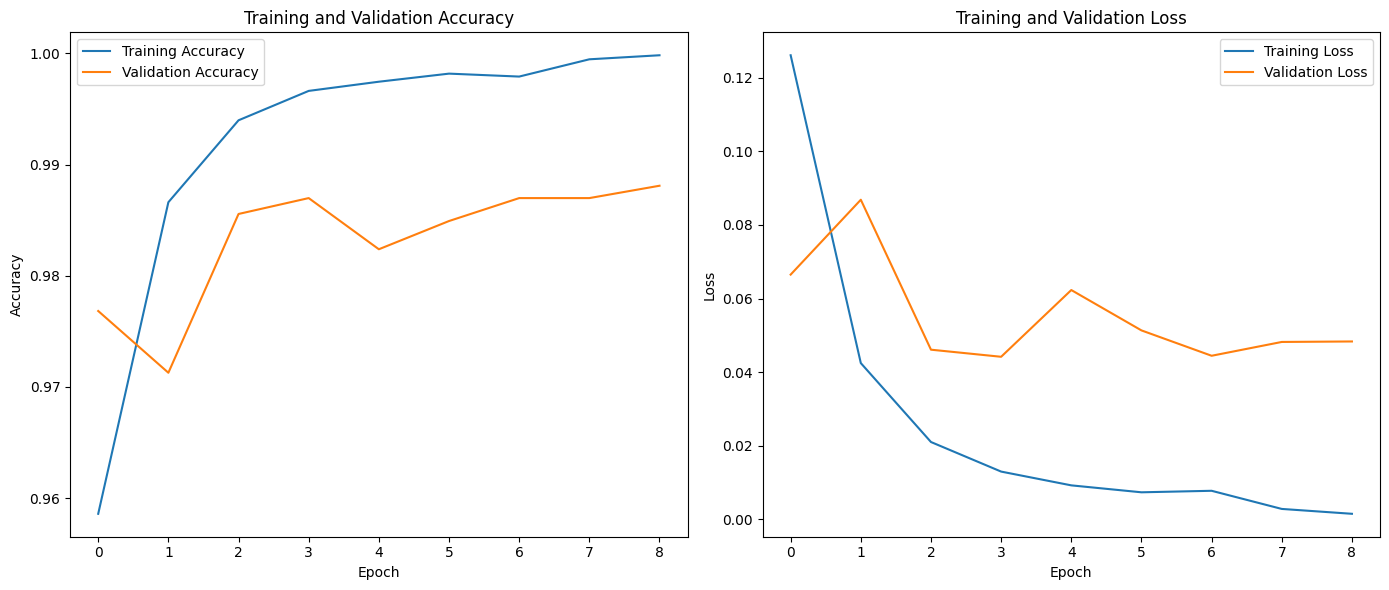

In [10]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

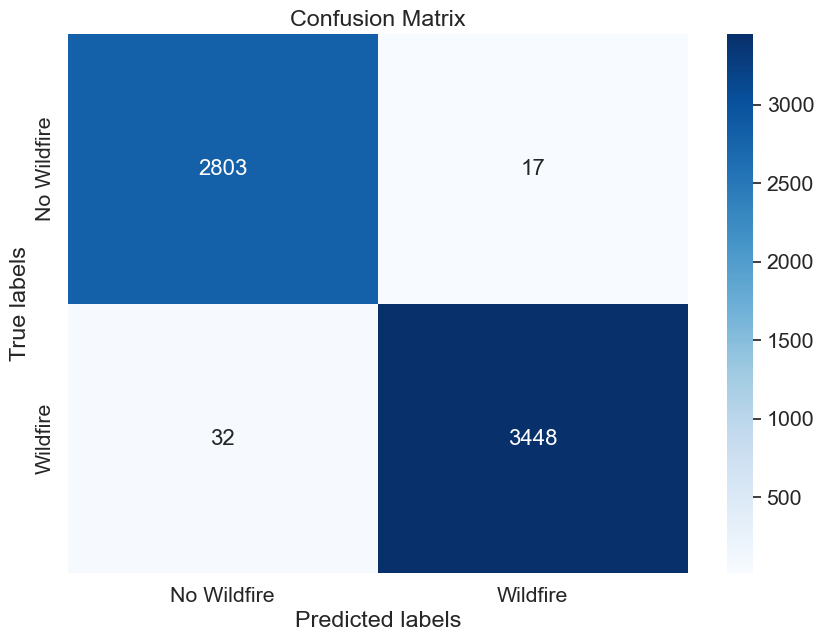

Accuracy: 99.22%
Classification Report:
              precision    recall  f1-score   support

 No Wildfire       0.99      0.99      0.99      2820
    Wildfire       1.00      0.99      0.99      3480

    accuracy                           0.99      6300
   macro avg       0.99      0.99      0.99      6300
weighted avg       0.99      0.99      0.99      6300



In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

model.eval()

test_preds = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        
        preds = torch.sigmoid(outputs) > 0.5
        test_preds.extend(preds.squeeze().cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

conf_matrix = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', xticklabels=['No Wildfire', 'Wildfire'], yticklabels=['No Wildfire', 'Wildfire'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

accuracy = accuracy_score(test_labels, test_preds)
report = classification_report(test_labels, test_preds, target_names=['No Wildfire', 'Wildfire'])

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)